In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import pandas as pd

In [2]:
tckrs = ["ADBE", "AMAT", "AMZN", "BRK-B", "DAL", "GOOG", "MCD"]

In [3]:
dates = pd.date_range("2019-12-18", "2021-11-01")

In [4]:
base = "/home/greg_b/voltron/experiments/trading/saved-outputs/"

In [5]:
full_predictions = []
has_dates = []
for date in dates:
    cap = str(date)[:10]
    try:
        predictions = torch.stack([torch.load(base + tckr + "/volt_ewma200_"+cap+".pt") for tckr in tckrs])
        full_predictions.append(predictions)
        has_dates.append(cap)
    except:
        print(cap)

2019-12-21
2019-12-22
2019-12-25
2019-12-28
2019-12-29
2020-01-01
2020-01-04
2020-01-05
2020-01-11
2020-01-12
2020-01-18
2020-01-19
2020-01-20
2020-01-25
2020-01-26
2020-02-01
2020-02-02
2020-02-08
2020-02-09
2020-02-15
2020-02-16
2020-02-17
2020-02-22
2020-02-23
2020-02-29
2020-03-01
2020-03-07
2020-03-08
2020-03-14
2020-03-15
2020-03-21
2020-03-22
2020-03-28
2020-03-29
2020-04-04
2020-04-05
2020-04-10
2020-04-11
2020-04-12
2020-04-18
2020-04-19
2020-04-25
2020-04-26
2020-05-02
2020-05-03
2020-05-09
2020-05-10
2020-05-16
2020-05-17
2020-05-23
2020-05-24
2020-05-25
2020-05-30
2020-05-31
2020-06-06
2020-06-07
2020-06-13
2020-06-14
2020-06-20
2020-06-21
2020-06-27
2020-06-28
2020-07-03
2020-07-04
2020-07-05
2020-07-11
2020-07-12
2020-07-18
2020-07-19
2020-07-25
2020-07-26
2020-08-01
2020-08-02
2020-08-08
2020-08-09
2020-08-15
2020-08-16
2020-08-22
2020-08-23
2020-08-29
2020-08-30
2020-09-05
2020-09-06
2020-09-07
2020-09-12
2020-09-13
2020-09-19
2020-09-20
2020-09-26
2020-09-27
2020-10-03

In [6]:
daily_predictions = torch.stack(full_predictions)

In [7]:
daily_predictions.shape

torch.Size([472, 7, 1000, 20])

In [8]:
from pandas.tseries.holiday import USFederalHolidayCalendar


In [9]:
date

Timestamp('2021-11-01 00:00:00', freq='D')

In [10]:
bday_us = pd.offsets.CustomBusinessDay(calendar=USFederalHolidayCalendar())

In [11]:
pd.date_range(start=date, periods=20, freq=bday_us)

DatetimeIndex(['2021-11-01', '2021-11-02', '2021-11-03', '2021-11-04',
               '2021-11-05', '2021-11-08', '2021-11-09', '2021-11-10',
               '2021-11-12', '2021-11-15', '2021-11-16', '2021-11-17',
               '2021-11-18', '2021-11-19', '2021-11-22', '2021-11-23',
               '2021-11-24', '2021-11-26', '2021-11-29', '2021-11-30'],
              dtype='datetime64[ns]', freq='C')

In [12]:
end_dates = [str(pd.date_range(start=date, periods=11, freq=bday_us)[-1])[:10] for date in has_dates]

In [13]:
observations = torch.tensor(
    [yf.download(tckr, start="2019-12-17", end="2021-12-01").Close.values for tckr in tckrs]
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


/tmp/ipykernel_10510/2577769575.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/torch/csrc/utils/tensor_new.cpp:201.)
  observations = torch.tensor(


In [14]:
observations.shape

torch.Size([7, 493])

In [15]:
observations = observations[..., :-1]

In [16]:
observations_for_cov = torch.tensor(
    [yf.download(tckr, start="2018-06-17", end="2021-12-01").Close.values for tckr in tckrs]
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [17]:
has_dates[-1]

'2021-11-01'

In [18]:
lookahead = 5

In [19]:
returns_for_cov = (observations_for_cov[..., lookahead:] - observations_for_cov[..., :-lookahead]) \
    / observations_for_cov[..., :-lookahead]

In [20]:
returns_for_cov = (returns_for_cov * 252 - 0.03 / 252) / lookahead

In [21]:
pd.date_range(start="2018-06-17", end="2019-12-17", freq=bday_us).shape

(377,)

In [22]:
batched_cov_estimate = torch.stack(
    [torch.cov(returns_for_cov[..., i:(377+i)]) for i in range(returns_for_cov.shape[-1] - 377)]
)

In [23]:
batched_cov_estimate.shape

torch.Size([489, 7, 7])

In [24]:
observations_for_cov.shape

torch.Size([7, 871])

In [25]:
num_obs = daily_predictions.shape[0]

In [26]:
observations[..., 15:-5].shape

torch.Size([7, 472])

In [27]:
observations.shape

torch.Size([7, 492])

In [28]:
daily_predictions.shape

torch.Size([472, 7, 1000, 20])

In [29]:
tenday_lookahead = daily_predictions[..., lookahead].permute(1, 2, 0)

In [30]:
tenday_lookahead.shape

torch.Size([7, 1000, 472])

In [31]:
exp_means = tenday_lookahead.exp().mean(1)
exp_stds = tenday_lookahead.exp().std(1)

In [32]:
exp_means.shape

torch.Size([7, 472])

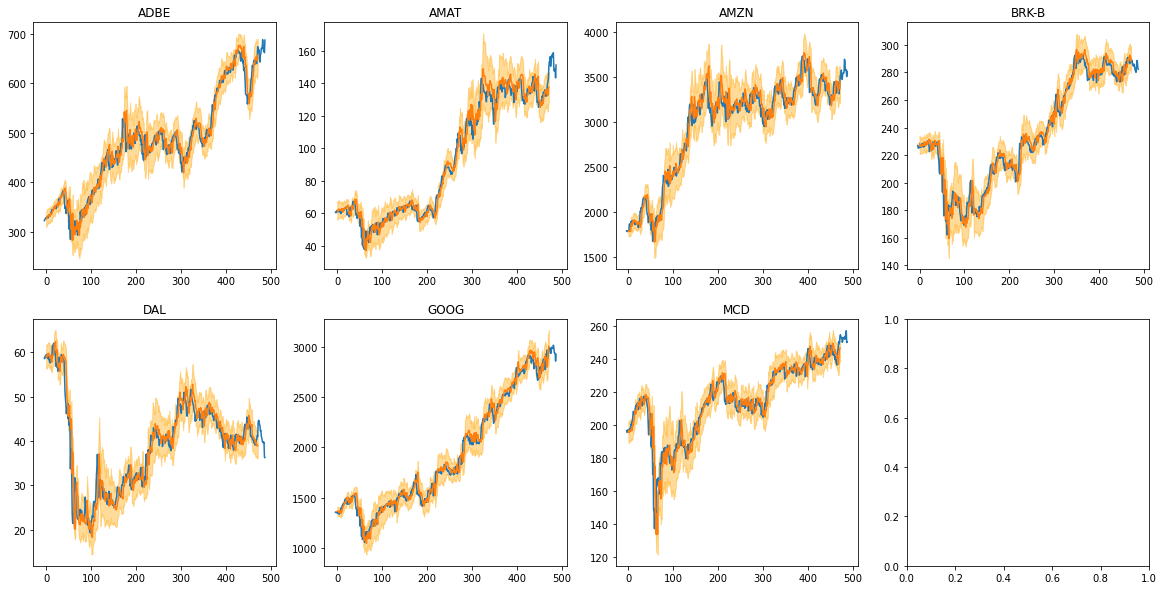

In [33]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
ax = ax.reshape(-1)

for i in range(7):
    ax[i].plot(torch.arange(-lookahead+1, -lookahead+num_obs+21), observations[i])
    ax[i].plot(exp_means[i])
    ax[i].fill_between(
        torch.arange(num_obs), 
        (exp_means - 2 * exp_stds)[i],
        (exp_means + 2 * exp_stds)[i],
        alpha = 0.4, 
        color = "orange"
    )
    ax[i].set_title(tckrs[i])

In [34]:
returns = (observations[...,lookahead:] - observations[..., (lookahead-1):-1]) / observations[..., (lookahead-1):-1]

In [35]:
returns = returns[..., :(num_obs)]

In [36]:
returns.shape

torch.Size([7, 472])

In [37]:
0.03 / 252

0.00011904761904761905

In [38]:
def construct_predicted_returns(preds, obs, interest_rate=0.03, num_diff=1):
    stock_returns = (preds - obs[..., :-20].unsqueeze(-2)) / obs[..., :-20].unsqueeze(-2)
    
    # compute annualized excess returns
    excess_returns = (stock_returns * 252 - interest_rate / 252) / num_diff
    return excess_returns

In [39]:
def compute_strategy(excess_returns, cov_est=None):
    if cov_est is None:
        batched_covs = torch.stack([torch.cov(excess_returns[..., i]) for i in range(excess_returns.shape[-1])])
    else:
        batched_covs = cov_est
    expected_returns = excess_returns.mean(1)
    
    weights = torch.solve(expected_returns.t().unsqueeze(-1), batched_covs)[0]
    norm_constant = expected_returns.t().unsqueeze(-2).matmul(weights).sum(-1)
    return weights.squeeze(-1) / norm_constant

In [40]:
tenday_lookahead.exp().shape

torch.Size([7, 1000, 472])

In [41]:
pred_excess_returns = construct_predicted_returns(tenday_lookahead.exp(), observations, num_diff=lookahead)

In [42]:
mean_excess_return = pred_excess_returns.mean(1)

(-5.0, 5.0)

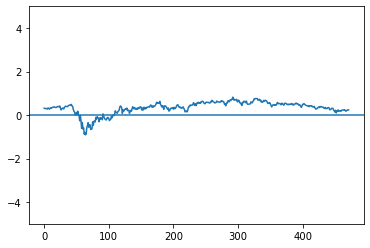

In [43]:
plt.plot(mean_excess_return.mean(0))
plt.axhline()
plt.ylim((-5, 5))

In [44]:
%pdb

Automatic pdb calling has been turned ON


In [45]:
batched_cov_estimate.shape

torch.Size([489, 7, 7])

In [46]:
cov_weights = compute_strategy(pred_excess_returns, cov_est=batched_cov_estimate[:-17]) 

/tmp/ipykernel_10510/195323174.py:8: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272204863/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  weights = torch.solve(expected_returns.t().unsqueeze(-1), batched_covs)[0]


In [47]:
weights = compute_strategy(pred_excess_returns) 

In [48]:
cov_observed_strat_returns = (cov_weights * returns.t()).sum(-1)

In [49]:
observed_strat_returns = (weights * returns.t()).sum(-1)

Text(0.5, 1.0, 'EWMA, k = 200')

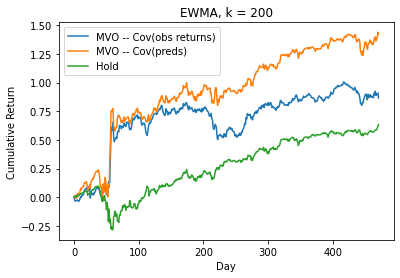

In [50]:
plt.plot(cov_observed_strat_returns.cumsum(0), label = "MVO -- Cov(obs returns)")
plt.plot(observed_strat_returns.cumsum(0), label = "MVO -- Cov(preds)")
plt.plot(returns.mean(0).cumsum(0), label = "Hold")
plt.legend()
plt.xlabel("Day")
plt.ylabel("Cumulative Return")
plt.title("EWMA, k = 200")

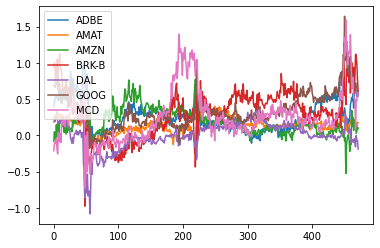

In [51]:
[plt.plot(weights[..., i], label = tckrs[i]) for i in range(7)]
plt.legend()